In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install jcopdl==1.1.10

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=d254ae556429dc5653219407c8590a60a39582e92dd5942fef13e94fb37b4cbd
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


**Import Library yang digunakan**

In [ ]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

**Configurasi Device**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

**Dataset dan data loader**

In [ ]:
#define trasnforms
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size,scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load the dataset
train_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/final dataset used for oil spill/dataset-final/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

val_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/final dataset used for oil spill/dataset-final/dataset/Validation", transform=val_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

In [ ]:
label2cat = train_set.classes
label2cat

['Non Oil Spill', 'Oil Spill']

**Arsitektur dan config**

In [ ]:
# Load arsitektur VGG16 dan Freeze weights
from torch.nn.modules import dropout
from torchvision.models import vgg16
mnet = vgg16(pretrained=True)
for param in mnet.parameters():
    param.requires_grad = False

# Configurasi Arsitektur VGG16 (Fully Connected Layer)
mnet.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 6)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]


In [ ]:
mnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class Customvgg16(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = vgg16(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
                nn.Linear(25088, 4096),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(4096, output_size)
            )

    def forward(self, x):
        return self.mnet(x)
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [ ]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

In [ ]:
model = Customvgg16(config.output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
    cost = correct = 0
    # Move tensors to the configured device
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        # Forward pass
        output = model(feature)
        loss = criterion(output, target)
        # Backward and optimize
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [ ]:
#Validation
epochs = 15
train_cost, val_cost = [], []
train_acc, val_acc = [], []
for i in range (epochs):
  cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  train_cost.append(cost)
  train_acc.append(acc)
  with torch.no_grad():
      cost, acc = loop_fn("val", val_set, valloader, model, criterion, optimizer, device)
      val_cost.append(cost)
      val_acc.append(acc)
  print(f"Epoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | val_cost: {val_cost[-1]:.4f} | "
        f" train_acc: {train_acc[-1]:.4f} | val_acc: {val_acc[-1]:.4f}")

Epoch: 1/15 | train_cost: 1.8062 | val_cost: 0.1692 |  train_acc: 0.8454 | val_acc: 0.9589
Epoch: 2/15 | train_cost: 0.0675 | val_cost: 0.0854 |  train_acc: 0.9811 | val_acc: 0.9786
Epoch: 3/15 | train_cost: 0.0484 | val_cost: 0.1403 |  train_acc: 0.9868 | val_acc: 0.9655
Epoch: 4/15 | train_cost: 0.0564 | val_cost: 0.0699 |  train_acc: 0.9821 | val_acc: 0.9720
Epoch: 5/15 | train_cost: 0.0325 | val_cost: 0.0552 |  train_acc: 0.9907 | val_acc: 0.9852
Epoch: 6/15 | train_cost: 0.0375 | val_cost: 0.0457 |  train_acc: 0.9925 | val_acc: 0.9852
Epoch: 7/15 | train_cost: 0.0406 | val_cost: 0.0254 |  train_acc: 0.9879 | val_acc: 0.9934
Epoch: 8/15 | train_cost: 0.0309 | val_cost: 0.0479 |  train_acc: 0.9925 | val_acc: 0.9901
Epoch: 9/15 | train_cost: 0.0327 | val_cost: 0.0517 |  train_acc: 0.9914 | val_acc: 0.9951
Epoch: 10/15 | train_cost: 0.0904 | val_cost: 0.1882 |  train_acc: 0.9832 | val_acc: 0.9819
Epoch: 11/15 | train_cost: 0.2034 | val_cost: 0.2651 |  train_acc: 0.9782 | val_acc: 0.98

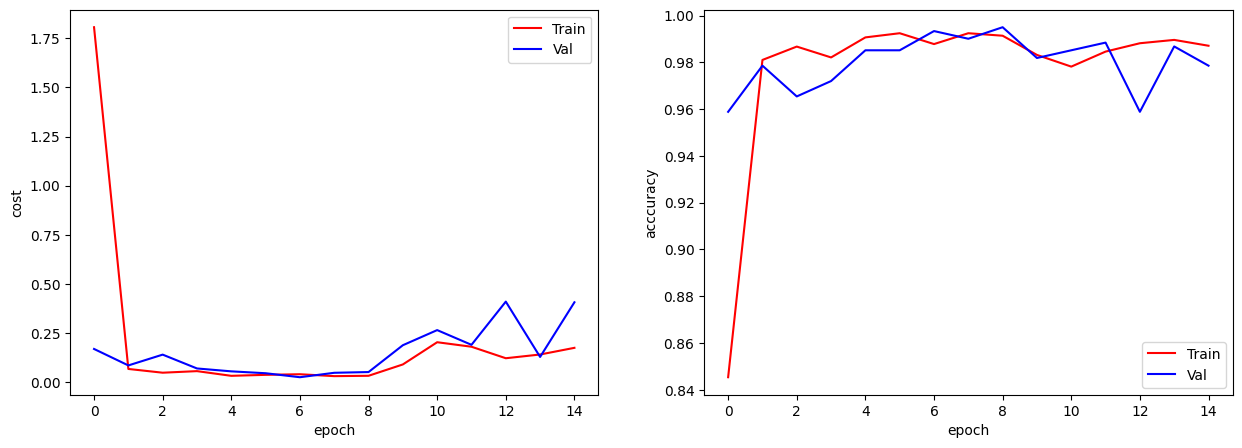

In [ ]:
#Plotting
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label='Train')
plt.plot(val_cost, 'b-', label='Val')
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.plot(train_acc, 'r-', label='Train')
plt.plot(val_acc, 'b-', label='Val')
plt.xlabel("epoch"); plt.ylabel("acccuracy"); plt.legend();

**Prediksi**

In [ ]:
feature, target = next(iter(valloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')

**Sanity Check**

In [ ]:
#inverse Images
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] = 0.229 + 0.485
    img[1, :, :] = img[1, :, :] = 0.224 + 0.456
    img[2, :, :] = img[2, :, :] = 0.225 + 0.406
    return img

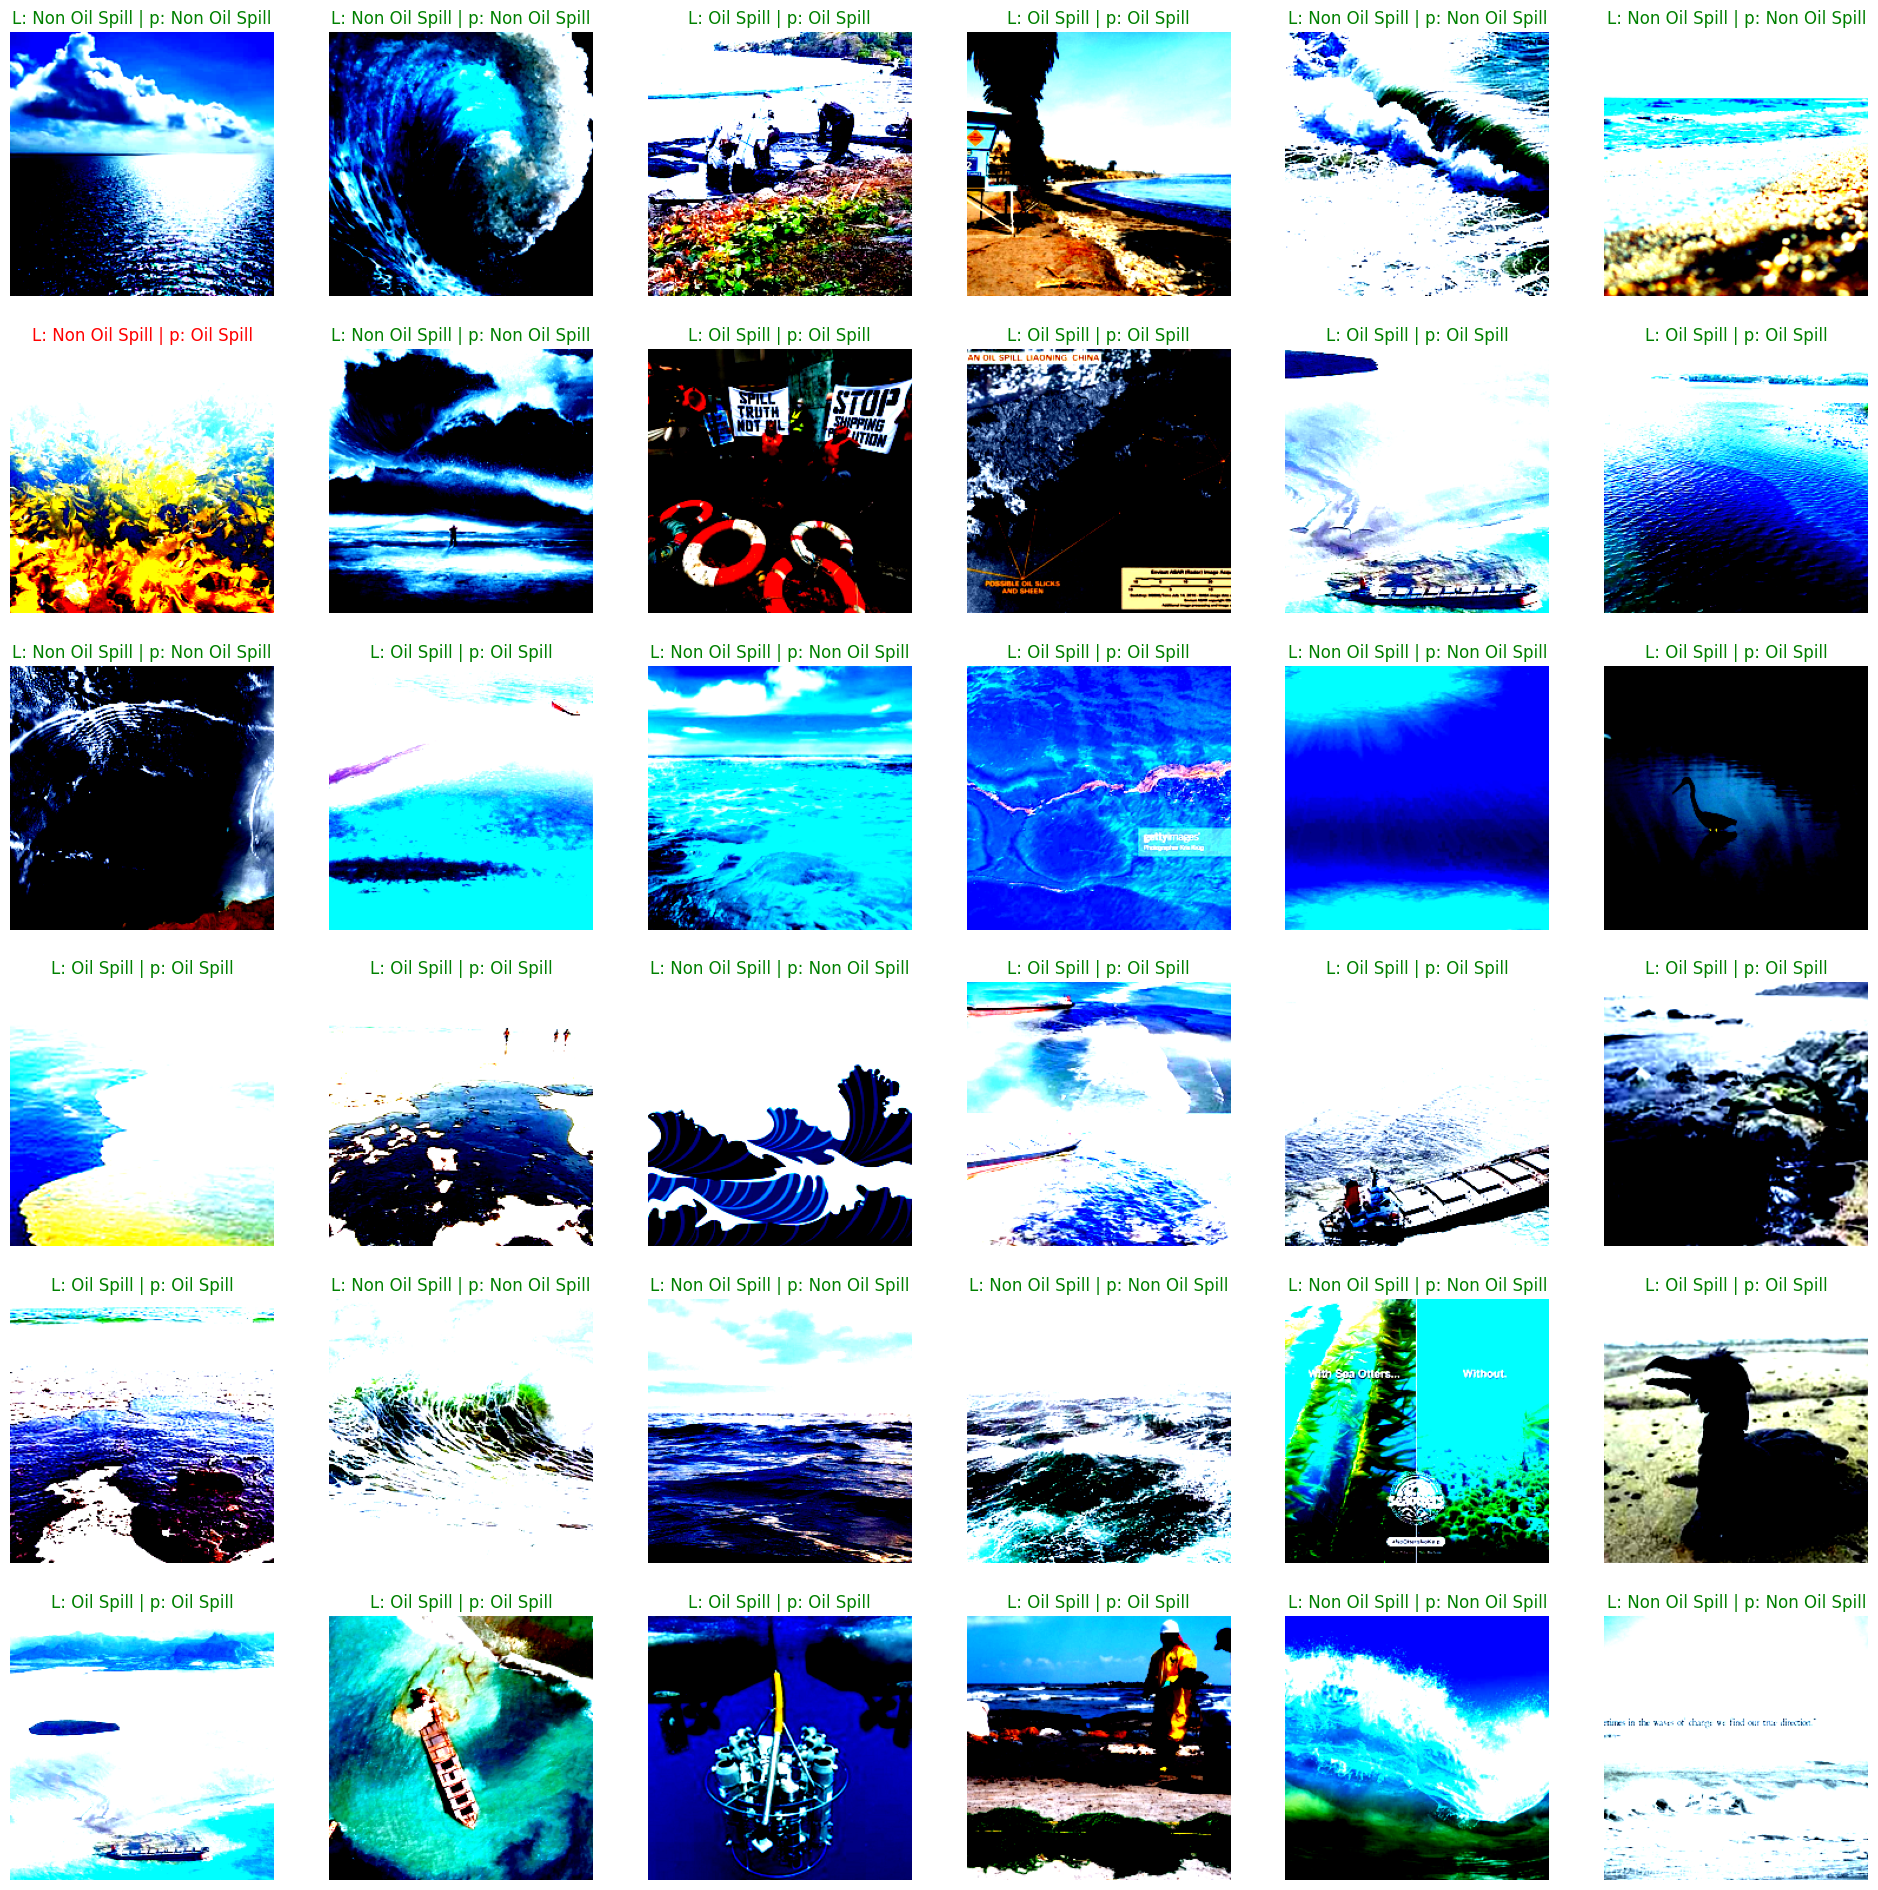

In [ ]:
#plot images hasil prediksi
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred =label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | p: {pred}", fontdict=font);
    ax.axis('off');

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/final dataset used for oil spill/model.pth')